In [2]:
# %matplotlib inline
import sys
import os
import pathlib
import pandas
import numpy
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

In [3]:
# Somehow you have to get the "dbuser" and "dbpasswd" variables
# filled with the right username and password to connect to the
# database.  You could do a prompt with input, for example.  But,
# don't code passwords into anything that will be public (e.g.
# committed to a github archive).  I have a "secrets" directory
# under my home directory that is *not* group or world readable,
# and I put files there that aren't group or world readable with
# passwords.  This still isn't great, but I decided that the tradeoff
# of having that there vs. having to type it every time I wanted
# to run the script was worth it.  (It also allows background
# execution.)

with open( pathlib.Path( os.getenv("HOME") ) / "secrets/decatdb_decat_decat_ro" ) as ifp:
    dbuser, dbpasswd = ifp.readline().strip().split()

In [4]:
# Connect to the database
db = psycopg2.connect( dbname="decat", host="decatdb.lbl.gov", port=5432, user=dbuser, password=dbpasswd,
                       cursor_factory=psycopg2.extras.RealDictCursor )
cursor = db.cursor()

In [5]:
tag = "latest"   # Eventually we'll probably want to use "default"
db.rollback()
q = ( "SELECT id,tag FROM versiontags WHERE tag=%(tag)s" )
cursor.execute( q, { "tag": tag } )
row = cursor.fetchone()
tagid = row['id']
print( f"Using tagid {tagid}" )


Using tagid 1


In [38]:
# Melissa's query
# (Modified to use a rb cutoff of 0.3, which is the criterion for alerts for rbtype 2)

q = ("SELECT od.ra, od.dec, od.mag, od.magerr, rbs.rb, i.filter, i.meanmjd, e.proposalid "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE od.ra > 5.0 AND od.ra < 12.0 AND od.dec > -46 AND od.dec < -41 "
     "AND rbs.rb > 0.3 "
     "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
     "e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
     "LIMIT 10000000" )
cursor.execute( q, { 'tagid': tagid } )
df = pandas.DataFrame( cursor.fetchall() )



In [39]:
clr_cosmos = 'dodgerblue'
clr_elais  = 'darkviolet'
fclr_cosmos = ['darkgreen', 'firebrick', 'saddlebrown']
fclr_elais  = ['limegreen', 'orange', 'lightcoral']
gx = numpy.where(df['filter'] == 'g')[0]
rx = numpy.where(df['filter'] == 'r')[0]
ix = numpy.where(df['filter'] == 'i')[0]

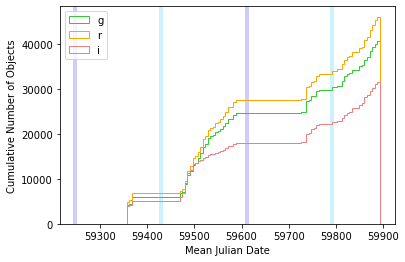

In [40]:
pyplot.axvline(59247, lw=4, alpha=0.2, color='blue')        # 2021A start
pyplot.axvline(59428, lw=4, alpha=0.2, color='deepskyblue') # 2021B start
pyplot.axvline(59612, lw=4, alpha=0.2, color='blue')        # 2022A start
pyplot.axvline(59793, lw=4, alpha=0.2, color='deepskyblue') # 2022B start

pyplot.hist(df['meanmjd'][gx], bins=100, histtype='step', cumulative=True, color=fclr_elais[0], label='g')
pyplot.hist(df['meanmjd'][rx], bins=100, histtype='step', cumulative=True, color=fclr_elais[1], label='r')
pyplot.hist(df['meanmjd'][ix], bins=100, histtype='step', cumulative=True, color=fclr_elais[2], label='i')
pyplot.xlabel('Mean Julian Date')
pyplot.ylabel('Cumulative Number of Objects')
pyplot.legend(loc='best')
pyplot.show()


In [41]:
# Is this right?
# Let's do a different query : objects per exposure
db.rollback()
q = ("SELECT e.id,e.filename,e.mjd,e.filter,COUNT(od.id) "
     "FROM objectdatas AS od "
     "INNER JOIN objectdata_versiontag AS odvt ON od.id=odvt.objectdata_id AND odvt.versiontag_id=%(tagid)s "
     "INNER JOIN objects AS o ON od.object_id=o.id "
     "INNER JOIN images AS i ON o.image_id=i.id "
     "INNER JOIN objectrbs as rbs ON od.id=rbs.objectdata_id AND rbs.rbtype_id=2 "
     "INNER JOIN exposures AS e ON i.exposure_id=e.id "
     "WHERE e.ra > 5.0 AND e.ra < 12.0 AND e.dec > -46 AND e.dec < -41 "
     "AND rbs.rb >= 0.3 "
     "AND (e.proposalid = '2021A-0113' OR e.proposalid = '2021B-0149' OR "
     "     e.proposalid = '2022A-724693' OR e.proposalid = '2022B-762878') "
     "GROUP BY e.id,e.filename,e.mjd,e.filter "
     "ORDER BY e.mjd "
     "LIMIT 10000000" )
cursor.execute( q, { 'tagid': tagid } )
df = pandas.DataFrame( cursor.fetchall() )
df

,id,filename,mjd,filter,count
0,1162,c4d_210522_083330_ori.fits.fz,59356.356605,g,25
1,1163,c4d_210522_083408_ori.fits.fz,59356.357045,g,66
2,1164,c4d_210522_083537_ori.fits.fz,59356.358075,r,106
3,1165,c4d_210522_083731_ori.fits.fz,59356.359396,i,89
4,1166,c4d_210522_084011_ori.fits.fz,59356.361243,g,76
...,...,...,...,...,...
2209,14140,c4d_221110_051952_ori.fits.fz,59893.222137,r,32
2210,14141,c4d_221110_052148_ori.fits.fz,59893.223483,i,19
2211,14142,c4d_221110_052426_ori.fits.fz,59893.225303,g,37
2212,14143,c4d_221110_052554_ori.fits.fz,59893.226320,r,40


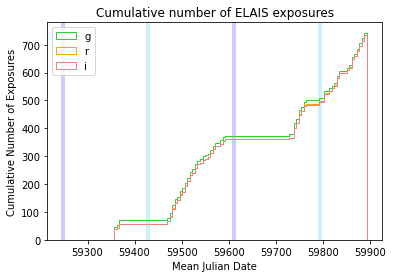

In [42]:
dfr = df[ df['filter']=='r' ]
dfg = df[ df['filter']=='g' ]
dfi = df[ df['filter']=='i' ]


pyplot.axvline(59247, lw=4, alpha=0.2, color='blue')        # 2021A start
pyplot.axvline(59428, lw=4, alpha=0.2, color='deepskyblue') # 2021B start
pyplot.axvline(59612, lw=4, alpha=0.2, color='blue')        # 2022A start
pyplot.axvline(59793, lw=4, alpha=0.2, color='deepskyblue') # 2022B start

pyplot.hist(dfg.mjd, bins=100, histtype='step', cumulative=True, color=fclr_elais[0], label='g')
pyplot.hist(dfr.mjd, bins=100, histtype='step', cumulative=True, color=fclr_elais[1], label='r')
pyplot.hist(dfi.mjd, bins=100, histtype='step', cumulative=True, color=fclr_elais[2], label='i')
pyplot.title('Cumulative number of ELAIS exposures')
pyplot.xlabel('Mean Julian Date')
pyplot.ylabel('Cumulative Number of Exposures')
pyplot.legend(loc='best')
pyplot.show()

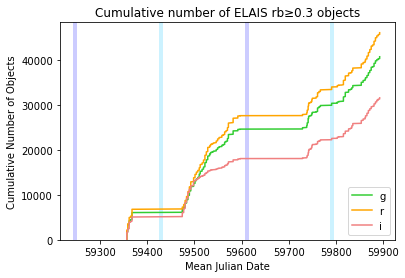

In [48]:
# This should be the same as the plot from melissa's query

pyplot.axvline(59247, lw=4, alpha=0.2, color='blue')        # 2021A start
pyplot.axvline(59428, lw=4, alpha=0.2, color='deepskyblue') # 2021B start
pyplot.axvline(59612, lw=4, alpha=0.2, color='blue')        # 2022A start
pyplot.axvline(59793, lw=4, alpha=0.2, color='deepskyblue') # 2022B start

pyplot.plot(dfg.mjd, dfg['count'].cumsum(), color=fclr_elais[0], label='g')
pyplot.plot(dfr.mjd, dfr['count'].cumsum(), color=fclr_elais[1], label='r')
pyplot.plot(dfi.mjd, dfi['count'].cumsum(), color=fclr_elais[2], label='i')
pyplot.title('Cumulative number of ELAIS rb≥0.3 objects')
pyplot.xlabel('Mean Julian Date')
pyplot.ylabel('Cumulative Number of Objects')
pyplot.legend(loc='best')
(ymin, ymax) = pyplot.gca().get_ylim()
pyplot.ylim( 0, ymax )
pyplot.show()

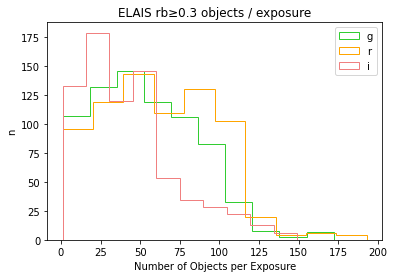

In [44]:
pyplot.hist( dfg['count'], color=fclr_elais[0], histtype='step', label='g' )
pyplot.hist( dfr['count'], color=fclr_elais[1], histtype='step', label='r' )
pyplot.hist( dfi['count'], color=fclr_elais[2], histtype='step', label='i' )

pyplot.title('ELAIS rb≥0.3 objects / exposure')
pyplot.xlabel('Number of Objects per Exposure')
pyplot.ylabel('n')
pyplot.legend(loc='best')
pyplot.show()